Inspired by: https://chrisorm.github.io/NGP.html

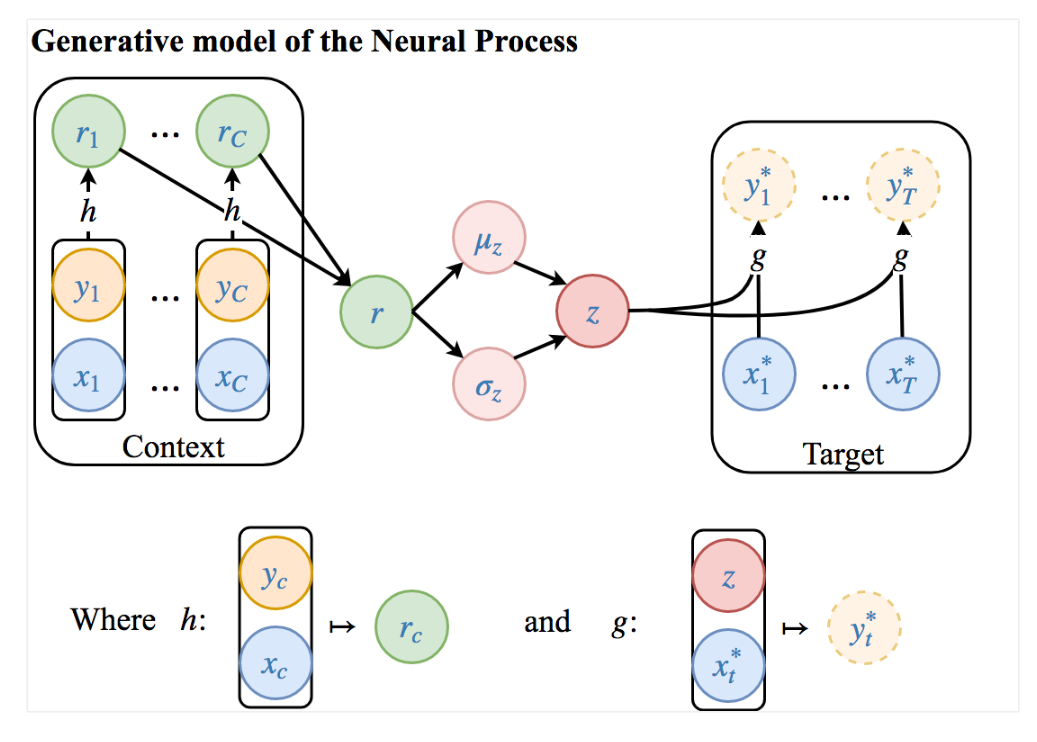

### Neural Process Model

1. **Encoding Context Points**  
   Each context point (x_c, y_c) is mapped through a neural network h to obtain a latent representation r_c.

2. **Aggregation**  
   The vectors r_c are aggregated (typically averaged) to obtain a single value r, which has the same dimensionality as each r_c.

3. **Latent Distribution**  
   The aggregated representation r is used to parameterize the distribution of z:  
   
   p(z | x_1:C, y_1:C) = N(μ_z(r), σ²_z(r))  
   
   where μ_z(r) and σ²_z(r) are functions of r.

4. **Prediction at Target Points**  
   - A latent variable z is sampled from the distribution.  
   - The sampled z is concatenated with a target input x*_t.  
   - This concatenated vector (z, x*_t) is mapped through another neural network g, which outputs a sample from the predictive distribution of y*_t.


### What we will now implement

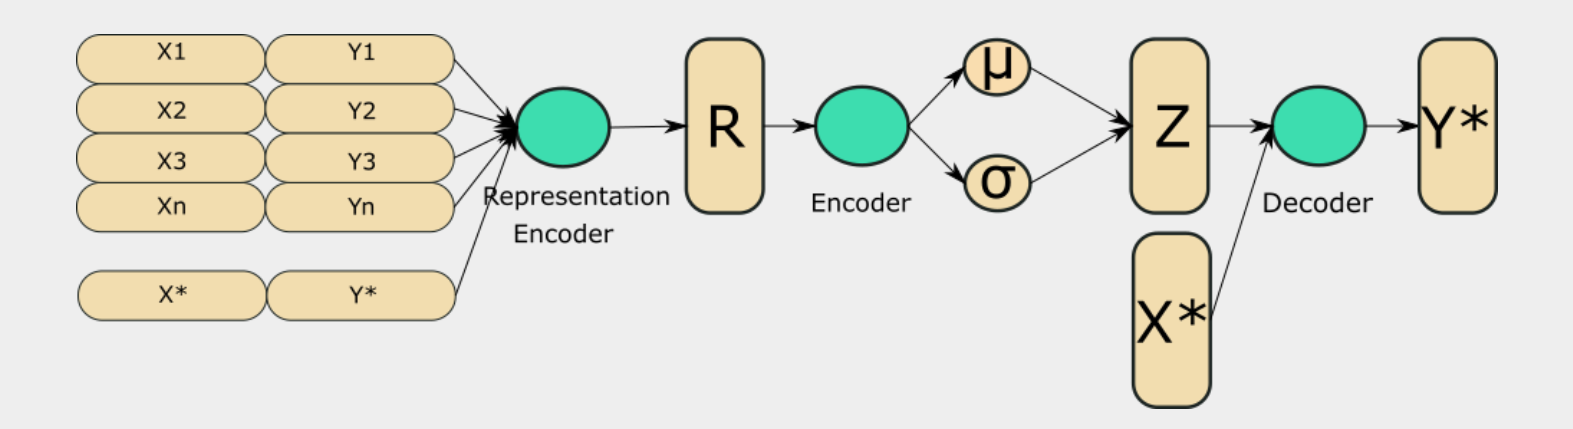

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class REncoder(torch.nn.Module):
    """Encodes inputs of the form (x_i,y_i) into representations, r_i."""
    
    def __init__(self, in_dim, out_dim, init_func = torch.nn.init.normal_):
        super(REncoder, self).__init__()
        self.l1_size = 8
        
        self.l1 = torch.nn.Linear(in_dim, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, out_dim)
        
        self.a = torch.nn.ReLU()

        # If the init_func is not None, then apply it on the weights of layer 1 and layer 2
        # This is the same as torch.nn.init.normal_(self.l1.weight)
        if init_func is not None:
            init_func(self.l1.weight)
            init_func(self.l2.weight)
        
    def forward(self, inputs):
        return self.l2(self.a(self.l1(inputs)))

In [3]:
class ZEncoder(torch.nn.Module):
    """Takes an r representation and produces the mean & standard deviation of the 
    normally distributed function encoding, z."""
    def __init__(self, in_dim, out_dim, init_func=torch.nn.init.normal_):
        super(ZEncoder, self).__init__()
        self.m1_size = out_dim
        self.std1_size = out_dim
        
        self.m1 = torch.nn.Linear(in_dim, self.m1_size)
        self.std1 = torch.nn.Linear(in_dim, self.m1_size)
        
        if init_func is not None:
            init_func(self.m1.weight)
            init_func(self.std1.weight)
        
    def forward(self, inputs):
        softplus = torch.nn.Softplus()
        return self.m1(inputs), softplus(self.std1(inputs))

In [4]:
class Decoder(torch.nn.Module):
    """
    Takes the x star points, along with a 'function encoding', z, and makes predictions.
    """
    def __init__(self, in_dim, out_dim, init_func=torch.nn.init.normal_):
        super(Decoder, self).__init__()
        self.l1_size = 8
        self.l2_size = 8
        
        self.l1 = torch.nn.Linear(in_dim, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, out_dim)
        
        if init_func is not None:
            init_func(self.l1.weight)
            init_func(self.l2.weight)
        
        self.a = torch.nn.Sigmoid()

    def forward(self, x_pred, z):
        """x_pred: No. of data points, by x_dim
        z: No. of samples, by z_dim
        """
        
        zs_reshaped = z.unsqueeze(-1).expand(z.shape[0], z.shape[1], x_pred.shape[0]).transpose(1,2)
#         z.unsqueeze(-1): Adds an extra dimension to z, changing its shape from (S, z_dim) to (S, z_dim, 1).
#         .expand(S, z_dim, N): Expands z along the last dimension to match the number of x_pred points, resulting in shape (S, z_dim, N).
#         .transpose(1, 2): Swaps the second and third dimensions, making the final shape (S, N, z_dim).
#         Purpose: This aligns z with x_pred, so each z sample is repeated for all x_pred points.
        
        xpred_reshaped = x_pred.unsqueeze(0).expand(z.shape[0], x_pred.shape[0], x_pred.shape[1])
#         x_pred.unsqueeze(0): Adds an extra batch dimension, changing its shape from (N, x_dim) to (1, N, x_dim).
#         .expand(S, N, x_dim): Expands x_pred across the S samples, making the final shape (S, N, x_dim).
#         Purpose: This ensures x_pred has the same batch structure as z, so they can be concatenated.
        
        xz = torch.cat([xpred_reshaped, zs_reshaped], dim=2)
#         Concatenates xpred_reshaped and zs_reshaped along the last dimension (dim=2).
#         Shape before concatenation:
#             xpred_reshaped: (S, N, x_dim)
#             zs_reshaped: (S, N, z_dim)
#         Shape after concatenation: (S, N, x_dim + z_dim).
#         Purpose: Combines the input features (x_pred) with their corresponding function encoding (z).
        
        return self.l2(self.a(self.l1(xz))).squeeze(-1).transpose(0,1), 0.005
        # Applies the first linear transformation: (S, N, x_dim + z_dim) → (S, N, 8).
        # Applies the Sigmoid activation function element-wise.
        # Passes through the second linear layer: (S, N, 8) → (S, N, out_dim).
        # If out_dim = 1, this removes the last dimension, making it (S, N).
        # Swaps the first and second dimensions, making the final shape (N, S).

        # Second return value
        # Likely represents a constant standard deviation for the predictive distribution p(y|x,z)

        
        


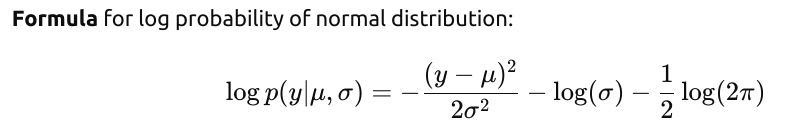

In [5]:
def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)

    ret = norm.log_prob(target).sum(dim=0).mean()
    # Computes the log probability density function (log-PDF) for the target values under the normal distribution
    # The output shape is (N, S) because:
    # mu and std have shape (N, S).
    # target is typically (N, 1) or (N,), and PyTorch automatically broadcasts it across S latent samples.
    # sum(dim=0): Sums the log probabilities across all data points (N), resulting in shape (S,). This means we now have one log-likelihood value per sample.
    # Takes the mean over all S latent samples, resulting in a scalar value. This final value represents the expected log-likelihood over different sampled latents.
    
    return ret

KL divergence measures how much one probability distribution differs from another. In VAEs, we use KL divergence to regularize the latent space, ensuring that 
𝑞
(
𝑧
)
 (the learned latent distribution) does not drift too far from 
𝑝
(
𝑧
)
 (the prior).

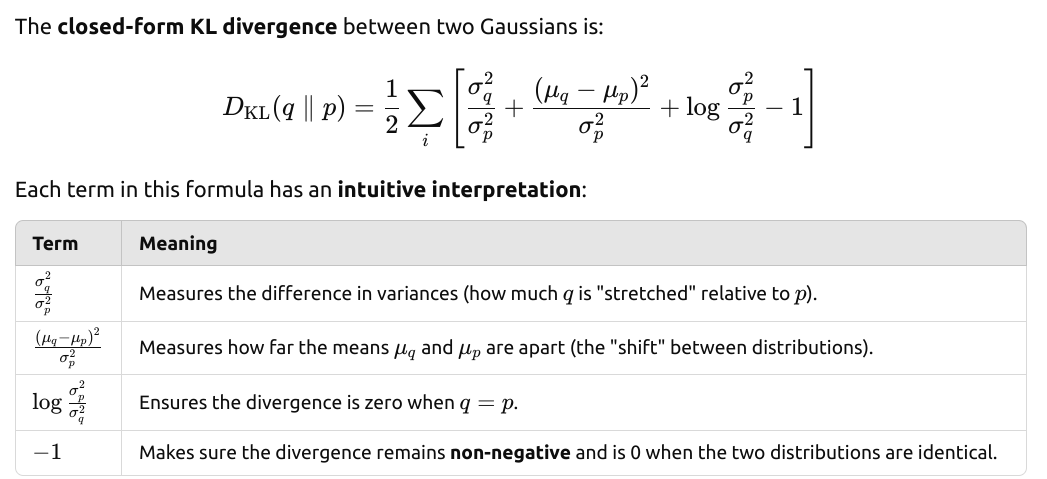
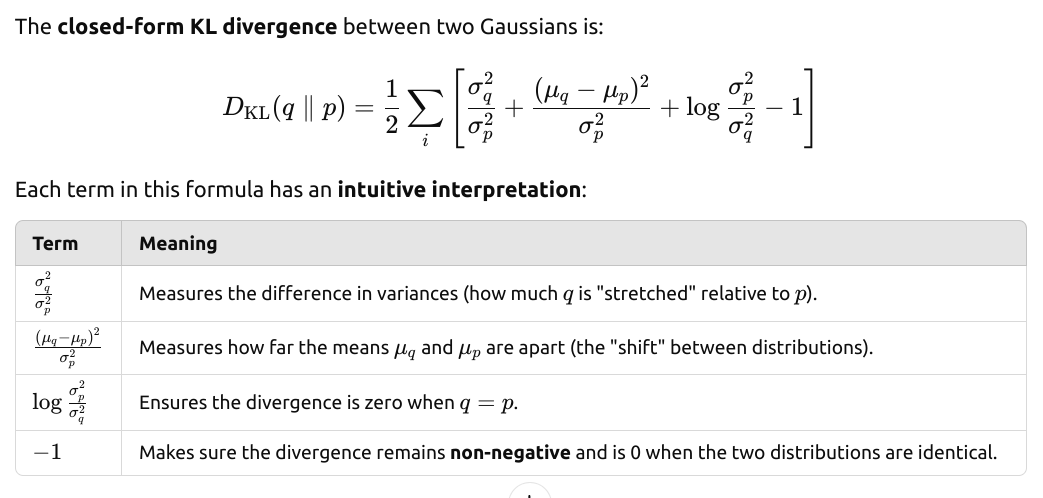

In [6]:
def KLD_gaussian(mu_q, std_q, mu_p, std_p):
    """Analytical KLD between 2 Gaussians."""
    qs2 = std_q**2 + 1e-16
    ps2 = std_p**2 + 1e-16
    
    return (qs2/ps2 + ((mu_q-mu_p)**2)/ps2 + torch.log(ps2/qs2) - 1.0).sum()*0.5

In [7]:
r_dim = 2
z_dim = 2
x_dim = 1
y_dim = 1
n_z_samples = 10 # Number of samples for Monte Carlo expecation of log likelihood
repr_encoder = REncoder(x_dim+y_dim, r_dim) # (x,y)->r
z_encoder = ZEncoder(r_dim, z_dim) # r-> mu, std
decoder = Decoder(x_dim+z_dim, y_dim) # (x*, z) -> y*
opt = torch.optim.Adam(list(decoder.parameters())+list(z_encoder.parameters())+
                       list(repr_encoder.parameters()), 1e-3)

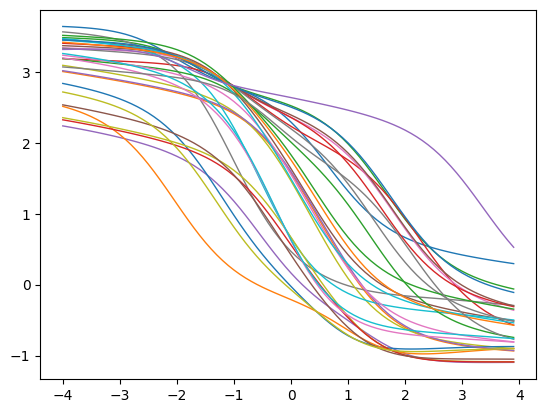

In [8]:
x_grid = torch.from_numpy(np.arange(-4,4, 0.1).reshape(-1,1).astype(np.float32))

untrained_zs = torch.from_numpy(np.random.normal(size=(30, z_dim)).astype(np.float32))
mu, _ = decoder(x_grid, untrained_zs)
for i in range(mu.shape[1]):
    plt.plot(x_grid.data.numpy(), mu[:,i].data.numpy(), linewidth=1)
plt.show()

In [9]:
def random_split_context_target(x,y, n_context):
    """Helper function to split randomly into context and target"""
    ind = np.arange(x.shape[0])
    mask = np.random.choice(ind, size=n_context, replace=False)
    return x[mask], y[mask], np.delete(x, mask, axis=0), np.delete(y, mask, axis=0)
    # Third and Fourth return values are points excluding the selected points

#### Ask Sir about the following cell

In [10]:
def sample_z(mu, std, n):
    """Reparameterisation trick."""
    eps = torch.autograd.Variable(std.data.new(n,z_dim).normal_())
    # std.data.new(n, z_dim).normal_() creates a tensor of shape (n, z_dim), filled with samples from a standard normal distribution 𝑁(0,1). This tensor is stored as eps, representing random noise.
    
    return mu + std * eps

In [11]:
def data_to_z_params(x, y):
    """Helper to batch together some steps of the process."""
    xy = torch.cat([x,y], dim=1)
    rs = repr_encoder(xy)
    r_agg = rs.mean(dim=0) # Average over samples
    return z_encoder(r_agg) # Get mean and variance for q(z|...)

In [12]:
def visualise(x, y, x_star):
    z_mu, z_std = data_to_z_params(x,y)
    zsamples = sample_z(z_mu, z_std, 100)
    
    mu, _ = decoder(x_star, zsamples)
    for i in range(mu.shape[1]):
        plt.plot(x_star.data.numpy(), mu[:,i].data.numpy(), linewidth=1)
    plt.scatter(x.data.numpy(), y.data.numpy())
    plt.show()

In [13]:
all_x_np = np.arange(-2,3,1.0).reshape(-1,1).astype(np.float32)
all_y_np = np.sin(all_x_np)

The loss function in the following cell:

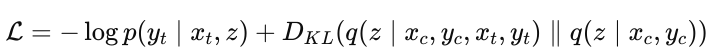

#### First term
The decoder outputs the predictive distribution 
𝑝
(
𝑦
∣
𝑥
,
𝑧
)
, characterized by:
𝜇
 (predicted mean of 
𝑦)
𝜎
(predicted standard deviation of 
𝑦)
The log-likelihood measures how probable the actual 
𝑦
𝑡.
  values are under this learned distribution.

We maximize the likelihood (equivalently, minimize the negative log-likelihood) to ensure the model makes accurate predictions.

#### Second term
This term measures the difference between:

The posterior 
𝑞
(
𝑧
∣
𝑥
𝑐
,
𝑦
𝑐
,
𝑥
𝑡
,
𝑦
𝑡
)
learned using both context and target data.
The prior 
𝑞
(
𝑧
∣
𝑥
𝑐
,
𝑦
𝑐
)
, which is only conditioned on context data.
If we minimize this KL divergence, we encourage:

The posterior to be similar to the prior.
The model to learn a meaningful latent space where the latent variable 
𝑧
doesn’t depend too much on extra target information.

In [14]:
def train(n_epochs, n_display=1000):
    losses = []
    for t in range(n_epochs): 
        opt.zero_grad()
        #Generate data and process
        x_context, y_context, x_target, y_target = random_split_context_target(
                                all_x_np, all_y_np, np.random.randint(1,4))
        x_c = torch.from_numpy(x_context)
        x_t = torch.from_numpy(x_target)
        y_c = torch.from_numpy(y_context)
        y_t = torch.from_numpy(y_target)

        x_ct = torch.cat([x_c, x_t], dim=0)
        y_ct = torch.cat([y_c, y_t], dim=0)

        # Get latent variables for target and context, and for context only.
        z_mean_all, z_std_all = data_to_z_params(x_ct, y_ct)
        z_mean_context, z_std_context = data_to_z_params(x_c, y_c)
        #Sample a batch of zs using reparam trick.
        zs = sample_z(z_mean_all, z_std_all, n_z_samples)

        mu, std = decoder(x_t, zs) # Get the predictive distribution of y*
        #Compute loss and backprop
        loss = -log_likelihood(mu, std, y_t) + KLD_gaussian(z_mean_all, z_std_all,
                                                            z_mean_context, z_std_context)
        losses.append(loss)
        loss.backward()
        opt.step()

        if t % n_display ==0:
            print(f"Function samples after {t} steps:")
            x_g = torch.from_numpy(np.arange(-4,4, 0.1).reshape(-1,1).astype(np.float32))
            visualise(x_ct, y_ct, x_g)
    return losses

Function samples after 0 steps:


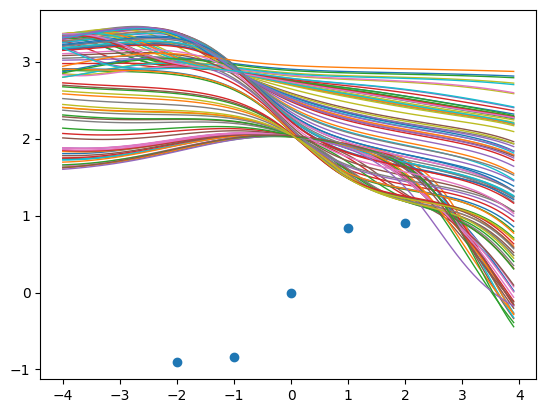

Function samples after 1000 steps:


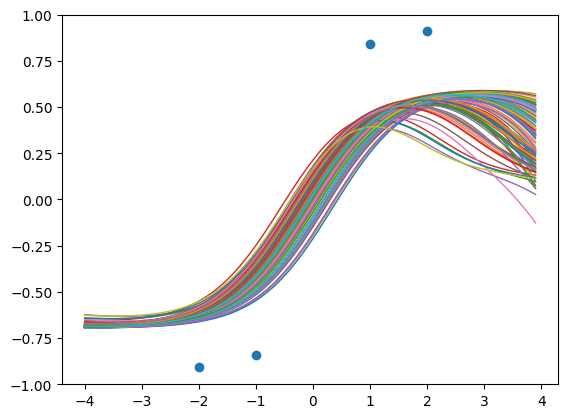

Function samples after 2000 steps:


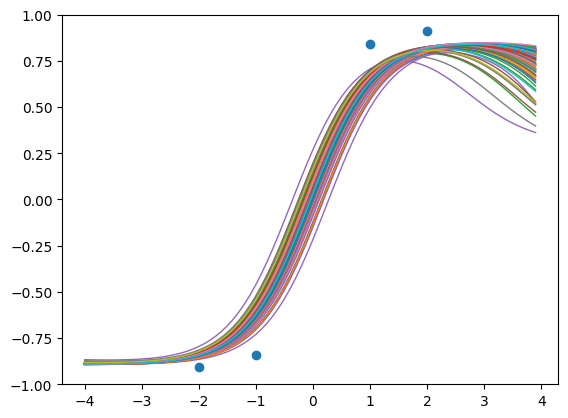

Function samples after 3000 steps:


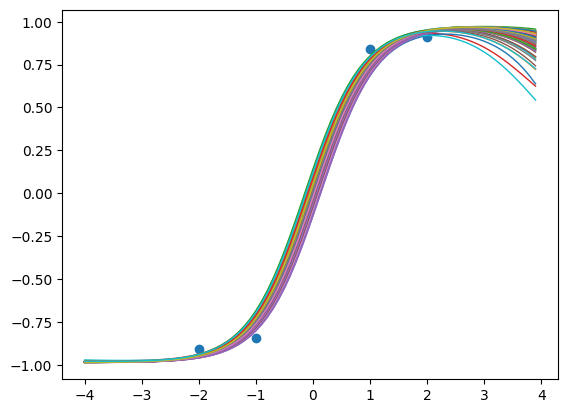

Function samples after 4000 steps:


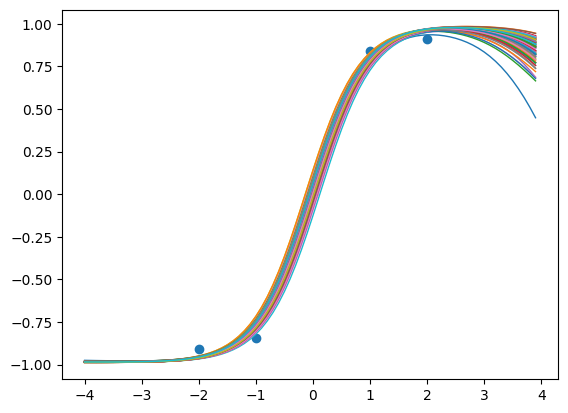

Function samples after 5000 steps:


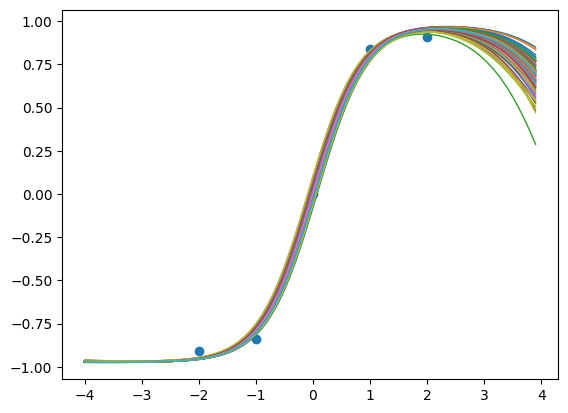

Function samples after 6000 steps:


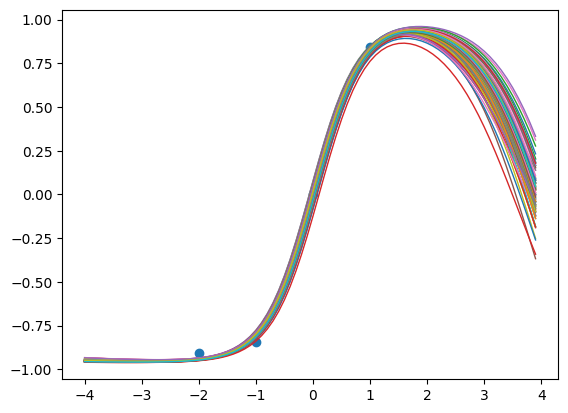

Function samples after 7000 steps:


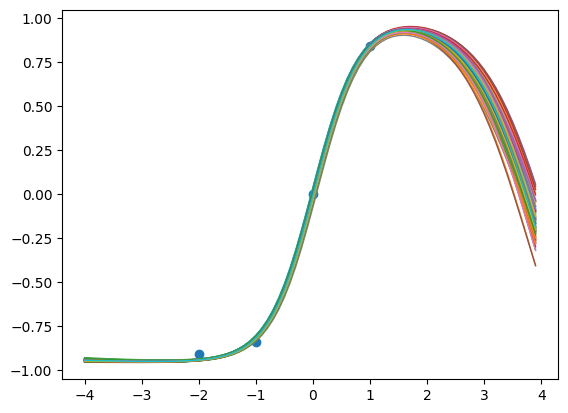

Function samples after 8000 steps:


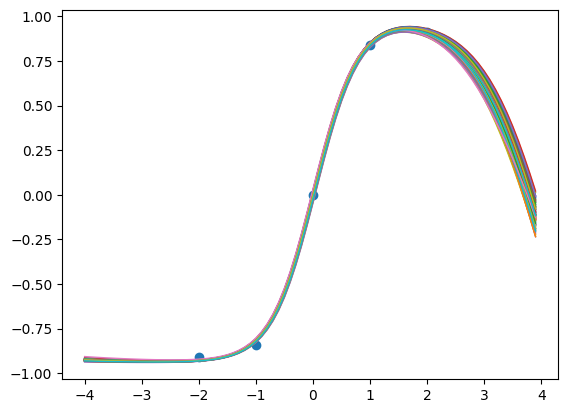

Function samples after 9000 steps:


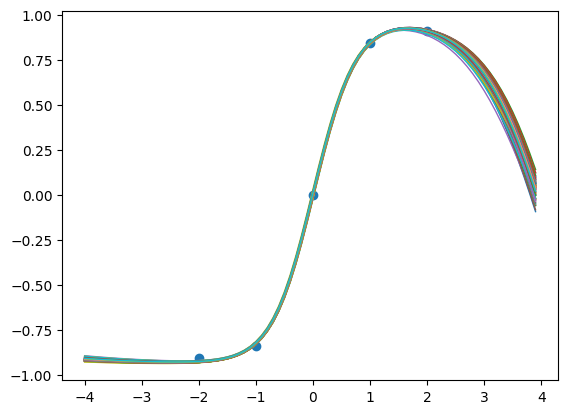

Function samples after 10000 steps:


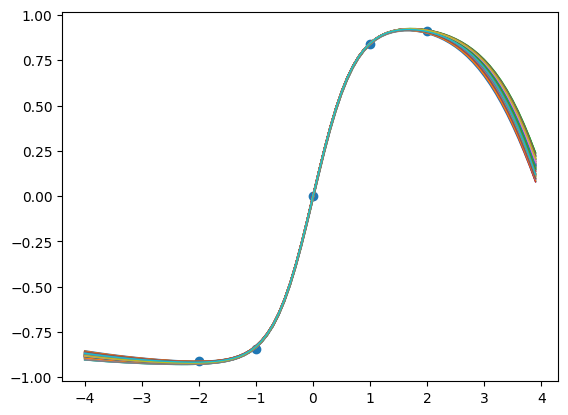

In [15]:
l = train(10001)